###**Name: Konstantinos Giatras**

###**Course: Algorithms in Structural Bioinformatics**

###**Assignment #1**

###**Date: 30/03/2023**



# 1. RNA Folding


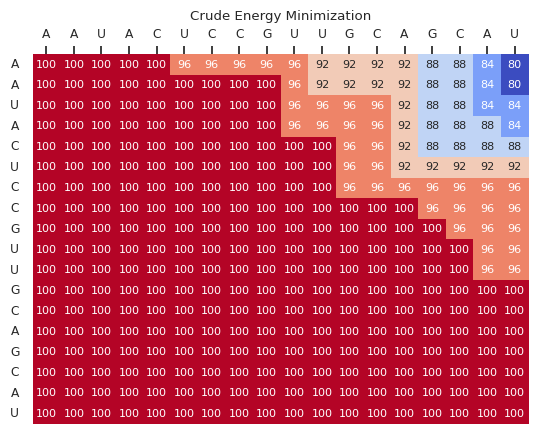

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define RNA sequence
rna_seq = "AAUACUCCGUUGCAGCAU"
n = len(rna_seq)

# Define energy function
def energy(r1, r2):
    """
    Calculate the energy of a pair of RNA bases based on the given rules.

    Parameters:
    r1 (str): First RNA base
    r2 (str): Second RNA base

    Returns:
    energy (int): Energy of the RNA base pair
    """
    if (r1 == 'A' and r2 == 'U') or (r1 == 'U' and r2 == 'A') or (r1 == 'C' and r2 == 'G') or (r1 == 'G' and r2 == 'C'):
        return -4
    elif (r1 == 'G' and r2 == 'U') or (r1 == 'U' and r2 == 'G'):
        return 0
    else:
        return 4

# Initialize energy matrix with high values
E = [[100 for j in range(n)] for i in range(n)]

# Fill in energy matrix
for i in range(n):
    for j in range(i-1, -1, -1):
        if j + 5 > i:
            # If i-j < 4, there is not enough space for a pair
            E[i][j] = 100
        else:
            # Four cases to consider
            case1 = E[i-1][j]
            case2 = E[i][j+1]
            case3 = E[i-1][j+1] + energy(rna_seq[i], rna_seq[j])
            case4_list = [E[i][k] + E[k-1][j] for k in range(j+1, i)]
            case4 = min(case4_list) if case4_list else 0
            E[i][j] = min(case1, case2, case3, case4)

# Convert energy matrix to numpy array and flip along major and minor diagonal
E = np.array(E)
E = np.flipud(np.fliplr(E).T)

# Create heatmap using seaborn
sns.set(font_scale=0.8)
ax = plt.axes()
sns.heatmap(E, annot=True, cmap="coolwarm", xticklabels=list(rna_seq), yticklabels=list(rna_seq), cbar=False, annot_kws={"size": 8}, fmt="d")
ax.set_title("Crude Energy Minimization")
ax.xaxis.set_ticks_position('top')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0) # rotate y tick labels to right
plt.savefig("CEM_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Initialize dot-parentheses string and stack for backtracking
fold = '.' * n
stack = []

# Start at top right corner of energy matrix
i, j = n-1, 0

# Traverse energy matrix using dynamic programming
while i > 0 or j < n-1:
    # Check which case the minimum energy value comes from
    if j + 1 <= i and E[i][j] == E[i][j+1] + energy(rna_seq[j+1], rna_seq[j]):
        # Case 2
        stack.append(j)
        j += 1
    elif i - 1 >= j and E[i][j] == E[i-1][j+1] + energy(rna_seq[i], rna_seq[j]):
        # Case 3
        stack.append(j)
        fold = fold[:j] + '(' + fold[j+1:i] + ')' + fold[i+1:]
        i -= 1
        j += 1
    else:
        # Case 4
        for k in range(j+1, i):
            if E[i][j] == E[i][k] + E[k-1][j]:
                # Found minimum energy value from case 4
                stack.append(j)
                stack.append(k)
                i, j = k-1, j+1
                break

# Add remaining base pair if necessary
if stack:
    fold = fold[:stack[-1]] + '(' + fold[stack[-1]+1:] + ')'

# Print results
print("RNA sequence: ", rna_seq)
print("Optimal fold: ", fold)

# 2. c-RMSD and d-RMSD

a

In [ ]:
import numpy as np

# Read in conformations from input file
with open("10_conformations.txt", "r") as f:
    lines = f.readlines()
    num_confs = int(lines[0].strip()) # Read number of conformations
    num_atoms = int(lines[1].strip()) # Read number of atoms per conformation
    conformations = []
    for i in range(num_confs):
        conf = []
        for j in range(num_atoms):
            coords = list(map(float, lines[2+i*num_atoms+j].strip().split())) # Read and store the coordinates of each atom for each conformation
            conf.append(coords)
        conformations.append(np.array(conf))

# Function to calculate c-RMSD distance between two pointsets
def c_rmsd(X, Y):
    n = X.shape[0]
    xc = np.mean(X, axis=0) # Calculate the center of mass of X
    yc = np.mean(Y, axis=0) # Calculate the center of mass of Y
    Xc = X - xc # Center X by subtracting the center of mass
    Yc = Y - yc # Center Y by subtracting the center of mass
    A = np.dot(Xc.T, Yc) # Calculate the matrix A
    U, S, Vt = np.linalg.svd(A) # Perform SVD on A
    if np.linalg.det(U) * np.linalg.det(Vt) < 0: # Ensure proper rotation
        S[-1] = -S[-1]
        U[:, -1] = -U[:, -1]
    R = np.dot(U, Vt) # Calculate the rotation matrix
    d = np.linalg.norm(Xc - np.dot(Yc, R), axis=1) # Calculate the deviation vector
    return np.sqrt(np.sum(d**2) / n) # Calculate the c-RMSD value

# Calculate and store pairwise c-RMSD distances between all pairs of conformations
distances = np.zeros((num_confs, num_confs))
for i in range(num_confs):
    for j in range(i+1, num_confs):
        distances[i,j] = c_rmsd(conformations[i], conformations[j])
        distances[j,i] = distances[i,j] # Distance matrix is symmetric

# Find L1-centroid conformation
min_sum_dist = float('inf')
centroid = None
for i in range(num_confs): # Looping through all conformations
    sum_dist = np.sum(distances[i,:]) # Computing the sum of distances to all other conformations for each conformation
    if sum_dist < min_sum_dist: # Selecting and storing the conformation with the minimum sum of distances
        min_sum_dist = sum_dist
        centroid = conformations[i]

# Print index of L1-centroid conformation and its sum of distances to all other conformations
centroid_idx = np.where(np.all(centroid == conformations, axis=(1,2)))[0][0]
print(f"L1-centroid conformation is conformation {centroid_idx} with sum of distances {min_sum_dist}")

L1-centroid conformation is conformation 3 with sum of distances 89.35966389127664


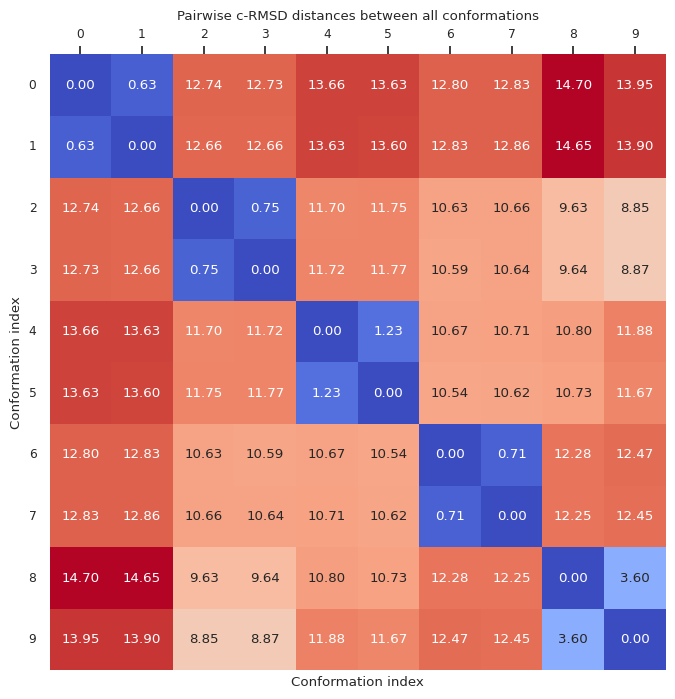

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create heatmap using seaborn
sns.set(font_scale=0.8)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(distances, cmap="coolwarm", annot=True, fmt=".2f", square=True, ax=ax, cbar=False)
ax.xaxis.set_ticks_position('top')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_title("Pairwise c-RMSD distances between all conformations")
ax.set_xlabel("Conformation index")
ax.set_ylabel("Conformation index")
plt.savefig("cRMSD_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

b1

In [ ]:
import numpy as np

# Load the data from the file
with open("10_conformations.txt", "r") as f:
    # Read the number of conformations and atoms
    n_conformations = int(f.readline().strip())
    n_atoms = int(f.readline().strip())
    # Read the coordinates of the atoms for each conformation
    conformations = []
    for i in range(n_conformations):
        coords = []
        for j in range(n_atoms):
            line = f.readline().strip().split()
            x, y, z = float(line[0]), float(line[1]), float(line[2])
            coords.append([x, y, z])
        conformations.append(np.array(coords))

# Compute the d-RMSD distances for each conformation
distances = []
for i in range(n_conformations):
    di = np.zeros((n_atoms, n_atoms))
    for j in range(n_atoms):
        for k in range(j + 1, n_atoms):
            dij = np.linalg.norm(conformations[i][j] - conformations[i][k])
            di[j, k] = di[k, j] = dij
    distances.append(di)

# Find the L1-centroid conformation
centroids = np.mean(conformations, axis=0)
centroid_distances = []
for i in range(n_conformations):
    dRMSD = np.sqrt(np.mean((distances[i] - distances[0]) ** 2))
    L1_distance = np.sum(np.abs(conformations[i] - centroids))
    centroid_distances.append((L1_distance, dRMSD, i))
centroid_distances.sort()

print("The L1-centroid conformation is:", centroid_distances[0][2])
print("The corresponding d-RMSD distance is:", centroid_distances[0][1])

The L1-centroid conformation is: 8
The corresponding d-RMSD distance is: 6.314273420963252


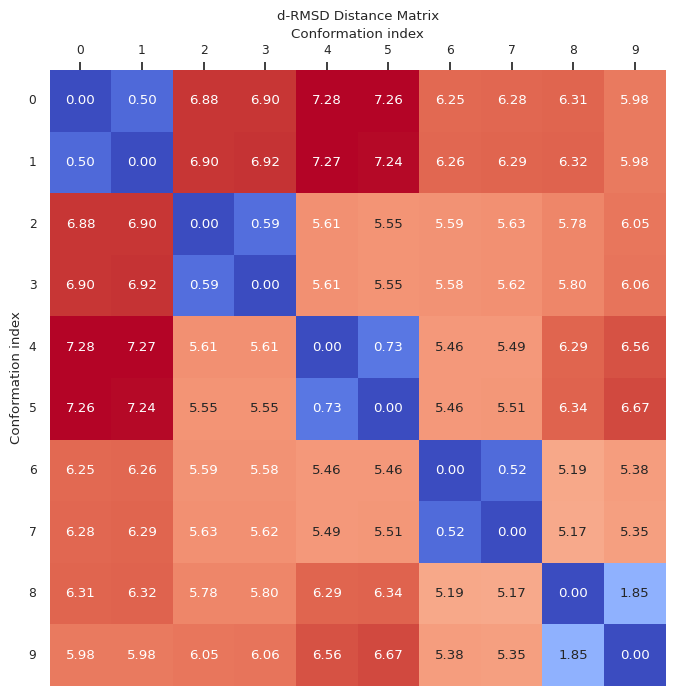

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create the heatmap
distance_matrix = np.zeros((n_conformations, n_conformations))
for i in range(n_conformations):
    for j in range(i + 1, n_conformations):
        distance_matrix[i, j] = distance_matrix[j, i] = np.sqrt(np.mean((distances[i] - distances[j]) ** 2))

# Set up the seaborn plot
sns.set(font_scale=0.8)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(distance_matrix, cmap="coolwarm", annot=True, fmt=".2f", square=True, ax=ax, cbar=False)
ax.xaxis.set_ticks_position('top')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.xaxis.set_label_position('top')
ax.set_xlabel("Conformation index")
ax.set_ylabel("Conformation index")
ax.set_title("d-RMSD Distance Matrix")
plt.savefig("dRMSD_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

b2

In [ ]:
import numpy as np

# Load the data from the file
with open("10_conformations.txt", "r") as f:
    # Read the number of conformations and atoms
    n_conformations = int(f.readline().strip())
    n_atoms = int(f.readline().strip())
    # Read the coordinates of the atoms for each conformation
    conformations = []
    for i in range(n_conformations):
        coords = []
        for j in range(n_atoms):
            line = f.readline().strip().split()
            x, y, z = float(line[0]), float(line[1]), float(line[2])
            coords.append([x, y, z])
        conformations.append(np.array(coords))

# Compute a random subset of distances for each conformation
k = 3 * n_atoms
distances = []
for i in range(n_conformations):
    indices = np.random.choice(n_atoms, size=k, replace=True)
    di = np.zeros((n_atoms, n_atoms))
    for j in range(k):
        for l in range(j + 1, k):
            jj, ll = indices[j], indices[l]
            dijl = np.linalg.norm(conformations[i][jj] - conformations[i][ll])
            di[jj, ll] = di[ll, jj] = dijl
    distances.append(di)

# Find the L1-centroid conformation
centroids = np.mean(conformations, axis=0)
centroid_distances = []
for i in range(n_conformations):
    dRMSD = np.sqrt(np.mean((distances[i] - distances[0]) ** 2))
    L1_distance = np.sum(np.abs(conformations[i] - centroids))
    centroid_distances.append((L1_distance, dRMSD, i))
centroid_distances.sort()

print("The L1-centroid conformation is:", centroid_distances[0][2])
print("The corresponding d-RMSD distance is:", centroid_distances[0][1])

The L1-centroid conformation is: 8
The corresponding d-RMSD distance is: 8.656910393682084


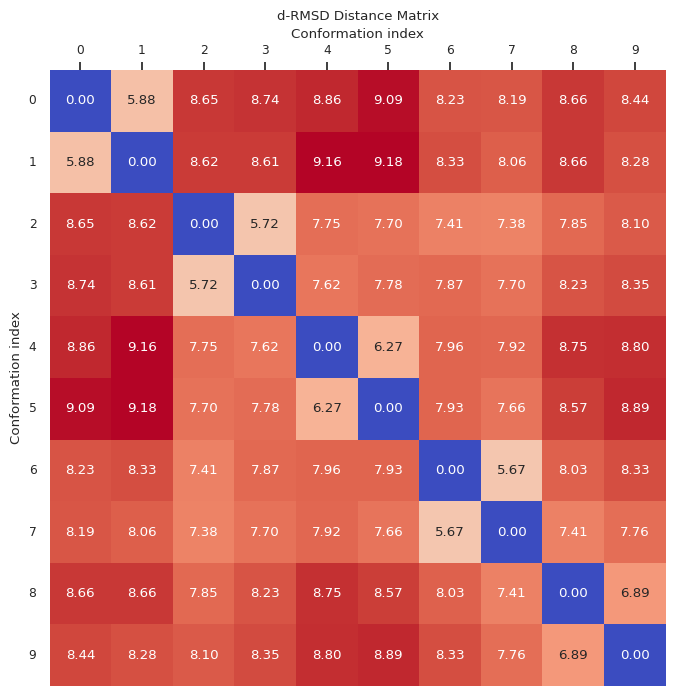

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create the heatmap
distance_matrix = np.zeros((n_conformations, n_conformations))
for i in range(n_conformations):
    for j in range(i + 1, n_conformations):
        distance_matrix[i, j] = distance_matrix[j, i] = np.sqrt(np.mean((distances[i] - distances[j]) ** 2))

# Set up the seaborn plot
sns.set(font_scale=0.8)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(distance_matrix, cmap="coolwarm", annot=True, fmt=".2f", square=True, ax=ax, cbar=False)
ax.xaxis.set_ticks_position('top')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.xaxis.set_label_position('top')
ax.set_xlabel("Conformation index")
ax.set_ylabel("Conformation index")
ax.set_title("d-RMSD Distance Matrix")
plt.savefig("dRMSD_heatmap2.png", dpi=300, bbox_inches='tight')
plt.show()

c

# 3. Distances

a

In [ ]:
# Import necessary modules
from Bio.PDB import *
import numpy as np

# Load the PDB file
parser = PDBParser()
structure = parser.get_structure('6LU7', '6LU7.pdb')

# Extract the coordinates of the first 50 alpha carbon atoms starting from A102
coords = []
for model in structure:
    for chain in model:
        for residue in chain:
            if residue.id[1] < 102:
                continue # skip residues before A102
            for atom in residue:
                if atom.name == 'CA':
                    coords.append(atom.coord)
                    if len(coords) == 50:
                        break
            if len(coords) == 50:
                break
        if len(coords) == 50:
            break

# Calculate the pairwise distances between the selected alpha carbon atoms
n = len(coords)
distances = np.zeros((n, n))
for i in range(n):
    for j in range(i+1, n):
        distance = np.linalg.norm(coords[i] - coords[j])
        distances[i,j] = distance
        distances[j,i] = distance

# Square each entry of the distance matrix
squared_distances = distances**2

# Construct the Cayley-Menger matrix using the squared distances
B = np.zeros((n+1, n+1))
B[1:,1:] = squared_distances
B[0,:] = 1
B[:,0] = 1
np.fill_diagonal(B, 0)

# Compute the rank of the matrix B with a given tolerance
rank = np.linalg.matrix_rank(B, tol=1e-9)

# Print the rank of the matrix B
print("Rank of the matrix B:", rank)

Rank of the matrix B: 50


/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2811.
  warnings.warn(


b

In [ ]:
# Perturb the matrix B by 5%
np.random.seed(123) # Set the random seed to ensure reproducibility
mask = B > 0 # Create a boolean mask to select positive entries of B
perturbation = 0.05 * np.random.rand(*B.shape) * mask # Create a perturbation matrix with 5% relative change
B_perturbed = B + perturbation # Add the perturbation matrix to B
B_perturbed = np.maximum(B_perturbed, 0) # Set negative entries to 0
B_perturbed = np.minimum(B_perturbed, 1) # Set entries larger than 1 to 1
B_perturbed = (B_perturbed + B_perturbed.T) / 2  # Enforce symmetry by taking the average of the matrix and its transpose
np.fill_diagonal(B_perturbed, 0) # Set the diagonal entries to 0 since they represent the distances between atoms with themselves

# Compute the rank of the perturbed matrix B with a given tolerance
rank_perturbed = np.linalg.matrix_rank(B_perturbed, tol=1e-9)

# Print the rank of  the perturbed matrix B
print("Rank of the perturbed matrix B:", rank_perturbed)

Rank of the perturbed matrix B: 51


In [ ]:
# Compute the Gram matrix
H = np.eye(n) - np.ones((n, n)) / n
G = -0.5 * np.dot(H, np.dot(distances**2, H))

# Perform SVD on G
U, s, Vt = np.linalg.svd(G)

# Get the top 3 singular values and construct S
S = np.diag(np.sqrt(s[:3]))

# Get the 3D coordinates
X = np.dot(S, U[:, :3].T).T

# Calculate the c-RMSD against the original structure
def c_rmsd(X, Y):
    n = X.shape[0]
    xc = np.mean(X, axis=0) # Calculate the center of mass of X
    yc = np.mean(Y, axis=0) # Calculate the center of mass of Y
    Xc = X - xc # Center X by subtracting the center of mass
    Yc = Y - yc # Center Y by subtracting the center of mass
    A = np.dot(Xc.T, Yc) # Calculate the matrix A
    U, S, Vt = np.linalg.svd(A) # Perform SVD on A
    if np.linalg.det(U) * np.linalg.det(Vt) < 0: # Ensure proper rotation
        S[-1] = -S[-1]
        U[:, -1] = -U[:, -1]
    R = np.dot(U, Vt) # Calculate the rotation matrix
    d = np.linalg.norm(Xc - np.dot(Yc, R), axis=1) # Calculate the deviation vector
    return np.sqrt(np.sum(d**2) / n) # Calculate the c-RMSD value

c_rmsd_value = c_rmsd(X, np.array(coords))

# Print the c-RMSD value
print("c-RMSD value:", c_rmsd_value)

c-RMSD value: 2.57984520554799
